In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt

In [3]:
# Load the data
df = pd.read_csv('../Churn_Modelling.csv')

In [4]:
# Preprocess the data
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [5]:
# Encode categorical variables
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])


In [6]:
# One-hot encode 'Geography'
df = pd.get_dummies(df, columns=['Geography'], prefix='Geography')

In [7]:
# Prepare features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

In [8]:
# Ensure y is properly encoded as 0 and 1
y = le.fit_transform(y)

In [9]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [11]:
with open('scaler_test.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [12]:
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


C:\Users\Pranav\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy',Recall(name='recall')])

In [15]:
# Setup callbacks
early_stopping_callback = EarlyStopping(monitor='val_recall', mode='max', patience=20, restore_best_weights=True)

In [16]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [17]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping_callback]
)

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5880 - loss: 0.6503 - recall: 0.6162 - val_accuracy: 0.7250 - val_loss: 0.5517 - val_recall: 0.7079
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.7129 - loss: 0.5623 - recall: 0.7382 - val_accuracy: 0.7680 - val_loss: 0.4664 - val_recall: 0.6629
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7442 - loss: 0.5379 - recall: 0.7244 - val_accuracy: 0.7670 - val_loss: 0.4785 - val_recall: 0.7079
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.7604 - loss: 0.5016 - recall: 0.7533 - val_accuracy: 0.7830 - val_loss: 0.4696 - val_recall: 0.6798
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7762 - loss: 0.4881 - recall: 0.7471 - val_accuracy: 0.8080 - val_loss: 0.4475 - val_recall: 0.6573
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.7756 - loss: 0.4861 - recall: 0.7330 - val_accuracy: 0.7990 - val_loss: 0.4586 - val_recal

In [18]:
# Evaluate on the test set
test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.7889 - loss: 0.4149 - recall: 0.7771
Test Accuracy: 0.7700
Test Recall: 0.7860


In [19]:
# Save the best model
best_recall = max(history.history['val_recall'])
best_epoch = history.history['val_recall'].index(best_recall)
print(f"Best validation recall: {best_recall:.4f} at epoch {best_epoch + 1}")
model.save('best_recall_model.keras')

Best validation recall: 0.7360 at epoch 46


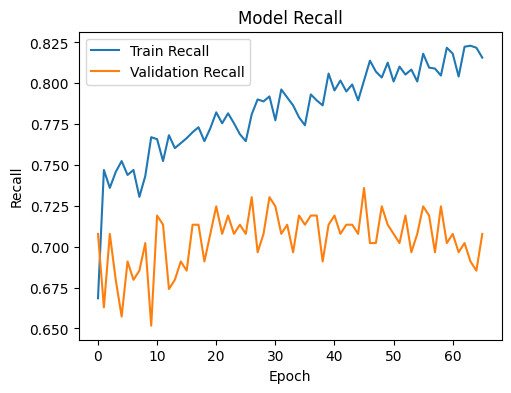

In [20]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

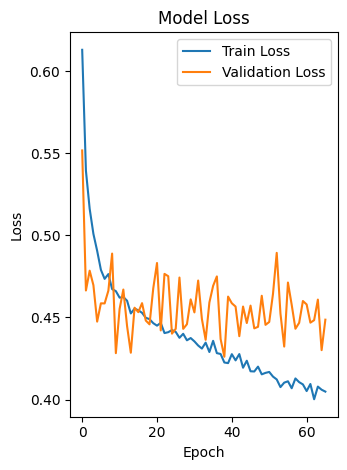

In [21]:
plt.subplot(122)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Print available keys in history
print("Available keys in history:")
print(history.history.keys())

Available keys in history:
dict_keys(['accuracy', 'loss', 'recall', 'val_accuracy', 'val_loss', 'val_recall'])


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [24]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [25]:
cm = confusion_matrix(y_test, y_pred_classes)

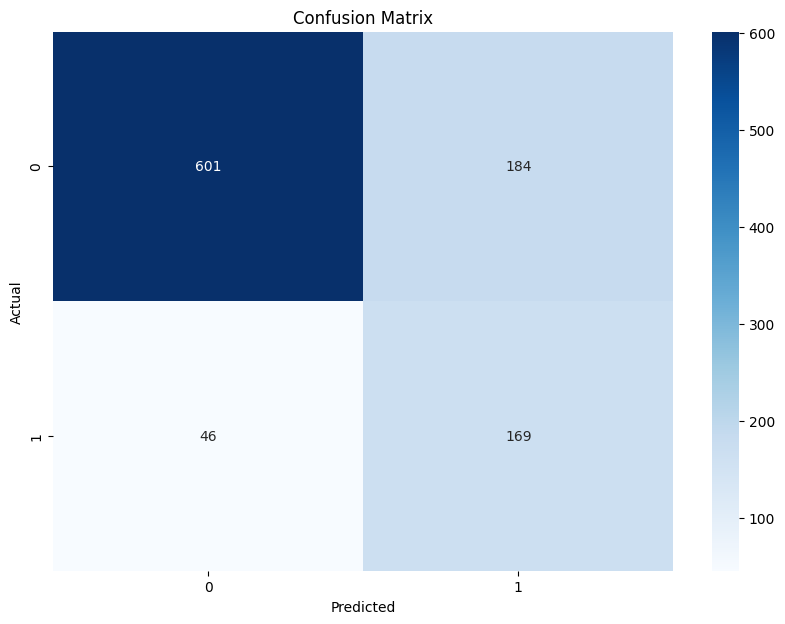

In [26]:
# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       785
           1       0.48      0.79      0.60       215

    accuracy                           0.77      1000
   macro avg       0.70      0.78      0.72      1000
weighted avg       0.83      0.77      0.79      1000



In [28]:
# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp)

In [29]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Specificity: {specificity:.4f}")

Precision: 0.4788
Recall: 0.7860
F1 Score: 0.5951
Specificity: 0.7656


Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       785
           1       0.43      0.75      0.55       215

    accuracy                           0.73      1000
   macro avg       0.67      0.74      0.68      1000
weighted avg       0.81      0.73      0.76      1000



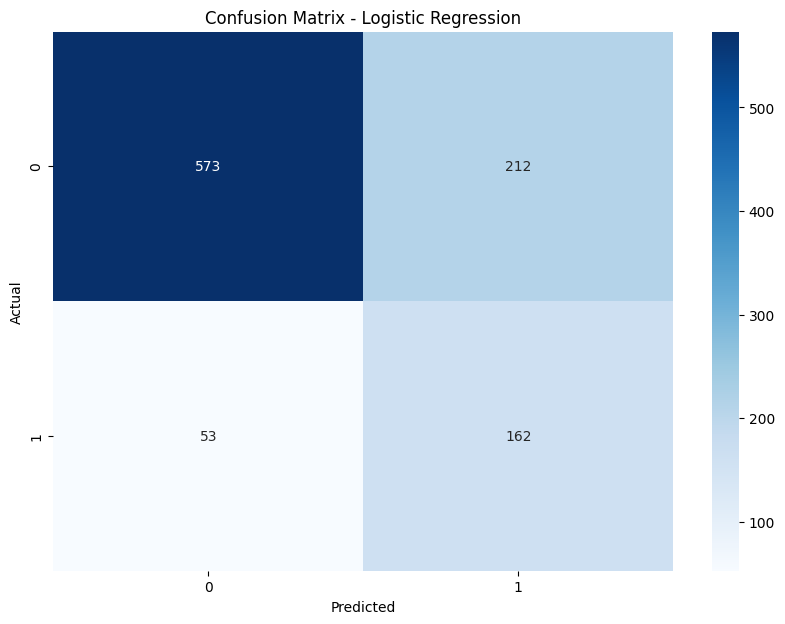

Logistic Regression Precision: 0.4332
Logistic Regression Recall: 0.7535
Logistic Regression F1 Score: 0.5501
Logistic Regression Specificity: 0.7299


In [30]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
lr_model.fit(X_train, y_train)

# Evaluate the model
y_pred_lr = lr_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate additional metrics for Logistic Regression
tn, fp, fn, tp = cm_lr.ravel()
precision_lr = tp / (tp + fp)
recall_lr = tp / (tp + fn)
f1_score_lr = 2 * (precision_lr * recall_lr) / (precision_lr + recall_lr)
specificity_lr = tn / (tn + fp)

print(f"Logistic Regression Precision: {precision_lr:.4f}")
print(f"Logistic Regression Recall: {recall_lr:.4f}")
print(f"Logistic Regression F1 Score: {f1_score_lr:.4f}")
print(f"Logistic Regression Specificity: {specificity_lr:.4f}")


Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       785
           1       0.83      0.52      0.64       215

    accuracy                           0.87      1000
   macro avg       0.86      0.75      0.78      1000
weighted avg       0.87      0.87      0.86      1000



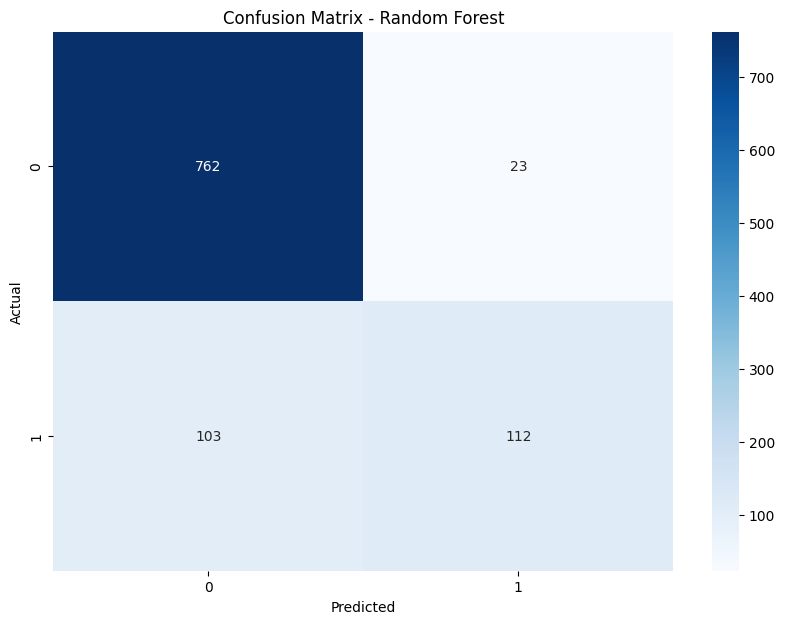

Random Forest Precision: 0.8296
Random Forest Recall: 0.5209
Random Forest F1 Score: 0.6400
Random Forest Specificity: 0.9707


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate additional metrics for Random Forest
tn, fp, fn, tp = cm_rf.ravel()
precision_rf = tp / (tp + fp)
recall_rf = tp / (tp + fn)
f1_score_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)
specificity_rf = tn / (tn + fp)

print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest Recall: {recall_rf:.4f}")
print(f"Random Forest F1 Score: {f1_score_rf:.4f}")
print(f"Random Forest Specificity: {specificity_rf:.4f}")


SVM:
              precision    recall  f1-score   support

           0       0.92      0.73      0.82       785
           1       0.44      0.78      0.57       215

    accuracy                           0.74      1000
   macro avg       0.68      0.76      0.69      1000
weighted avg       0.82      0.74      0.76      1000



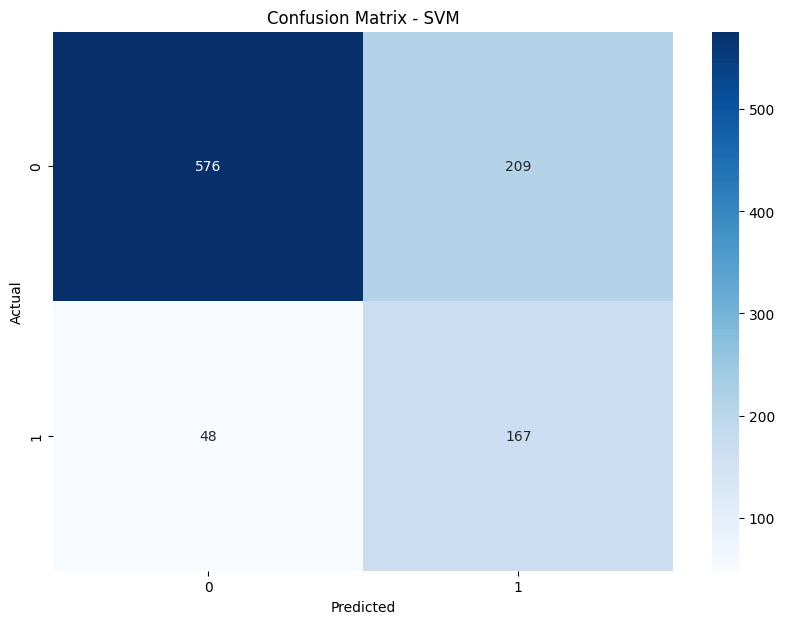

SVM Precision: 0.4441
SVM Recall: 0.7767
SVM F1 Score: 0.5651
SVM Specificity: 0.7338


In [33]:
from sklearn.svm import SVC

# Create SVM model
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True)

# Train the model
svm_model.fit(X_train, y_train)

# Evaluate the model
y_pred_svm = svm_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM:")
print(classification_report(y_test, y_pred_svm))

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate additional metrics for SVM
tn, fp, fn, tp = cm_svm.ravel()
precision_svm = tp / (tp + fp)
recall_svm = tp / (tp + fn)
f1_score_svm = 2 * (precision_svm * recall_svm) / (precision_svm + recall_svm)
specificity_svm = tn / (tn + fp)

print(f"SVM Precision: {precision_svm:.4f}")
print(f"SVM Recall: {recall_svm:.4f}")
print(f"SVM F1 Score: {f1_score_svm:.4f}")
print(f"SVM Specificity: {specificity_svm:.4f}")


K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       785
           1       0.68      0.43      0.53       215

    accuracy                           0.83      1000
   macro avg       0.77      0.69      0.71      1000
weighted avg       0.82      0.83      0.82      1000



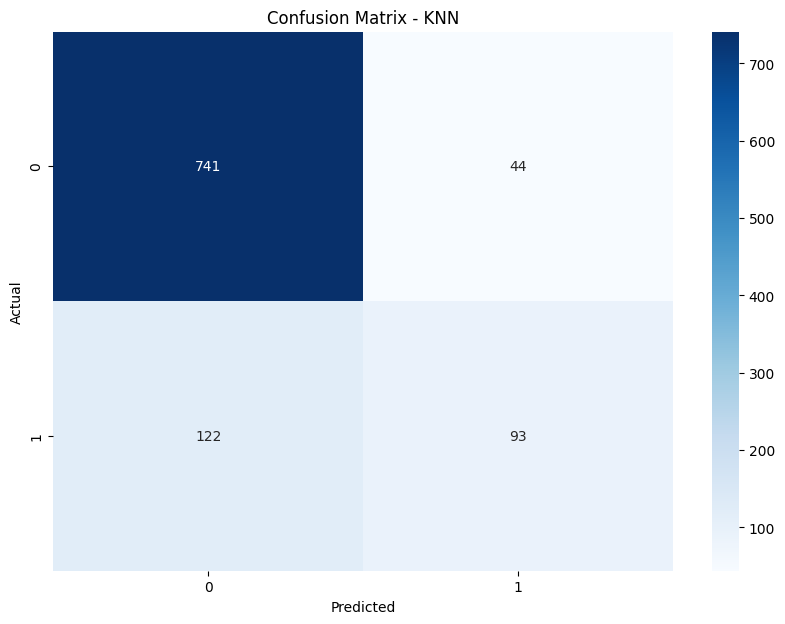

KNN Precision: 0.6788
KNN Recall: 0.4326
KNN F1 Score: 0.5284
KNN Specificity: 0.9439


In [34]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Evaluate the model
y_pred_knn = knn_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("K-Nearest Neighbors:")
print(classification_report(y_test, y_pred_knn))

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - KNN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate additional metrics for KNN
tn, fp, fn, tp = cm_knn.ravel()
precision_knn = tp / (tp + fp)
recall_knn = tp / (tp + fn)
f1_score_knn = 2 * (precision_knn * recall_knn) / (precision_knn + recall_knn)
specificity_knn = tn / (tn + fp)

print(f"KNN Precision: {precision_knn:.4f}")
print(f"KNN Recall: {recall_knn:.4f}")
print(f"KNN F1 Score: {f1_score_knn:.4f}")
print(f"KNN Specificity: {specificity_knn:.4f}")


d:\ANN Classification\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       785
           1       0.73      0.57      0.64       215

    accuracy                           0.86      1000
   macro avg       0.81      0.76      0.78      1000
weighted avg       0.85      0.86      0.86      1000



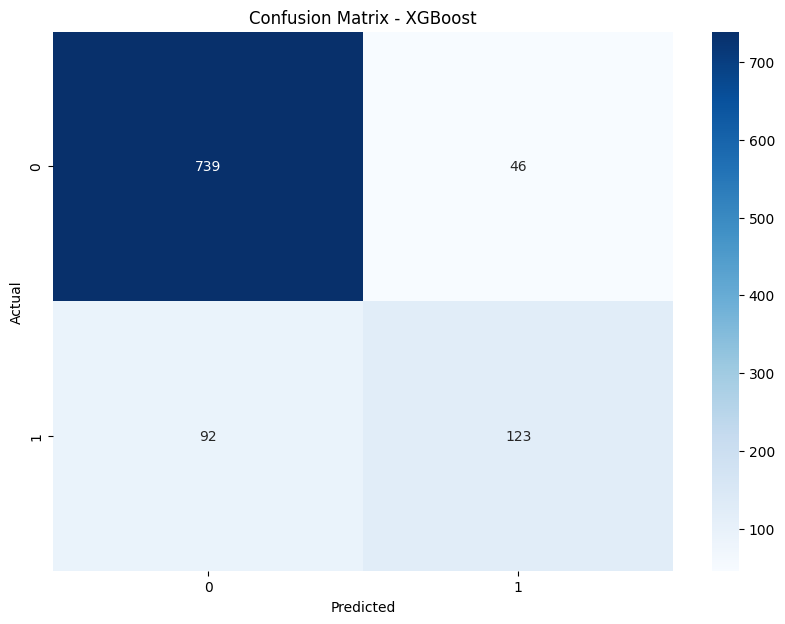

XGBoost Precision: 0.7278
XGBoost Recall: 0.5721
XGBoost F1 Score: 0.6406
XGBoost Specificity: 0.9414


In [37]:
from xgboost import XGBClassifier

# Create XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_test)

# Confusion Matrix and Classification Report
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate additional metrics for XGBoost
tn, fp, fn, tp = cm_xgb.ravel()
precision_xgb = tp / (tp + fp)
recall_xgb = tp / (tp + fn)
f1_score_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)
specificity_xgb = tn / (tn + fp)

print(f"XGBoost Precision: {precision_xgb:.4f}")
print(f"XGBoost Recall: {recall_xgb:.4f}")
print(f"XGBoost F1 Score: {f1_score_xgb:.4f}")
print(f"XGBoost Specificity: {specificity_xgb:.4f}")
